<a href="https://colab.research.google.com/github/uncultivate/Plant-Recommendations/blob/master/Plant_Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recommendation Systems with TensorFlow

This Colab notebook is adapted from Google's [Recommendation Systems with TensorFlow](https://developers.google.com/machine-learning/recommendation/) notebook, which uses matrix factorization to learn user and movie embeddings. Check out the course if you would like to learn more about creating recommendation models with TensorFlow.



# Introduction

We will create a plant recommendation system based on the [Atlas of Living Australia (ALA)](https://ala.org.au/) dataset available [here](https://spatial.ala.org.au/).  The data consists of plant species observations & locations.

## Outline
  1. Exploring the ALA Data
  1. Preliminaries
  1. Training a matrix factorization model
  1. Inspecting the Embeddings
  1. Regularization in matrix factorization


## Setup

Let's get started by importing the required packages.

In [ ]:
# @title Imports (run this cell)
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Instructions for updating:
non-resource variables are not supported in the long term
Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-khuytmyz
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-khuytmyz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=731330 sha256=b411b887f6f0a511808ee1b0818b22491eab9f322048a3cfcd8a7a4f25c56a4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yl3ek7go/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
  Found existing installation: altair 4.1.0
    Uninstalling altair-4.1.0:
      Successfully uninstalled altair-4.1.0
Done installing Altair.


We then download the Atlas of Living Australia Data, and create dataframes containing locations and plant sightings.

In [ ]:
#@title Load the Atlas of Living Australia data (run this cell).

# Download ALA data.
print("Downloading ALA data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("https://github.com/redseraph/redseraph.github.io/blob/master/assets/plantsdb1.zip?raw=true", "plantsdb1.zip")
zip_ref = zipfile.ZipFile('plantsdb1.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains 69,049 plant observations around NSW taken in 2020")


# Load the plants dataset and create dataframe
plants = pd.read_csv('plantsdb1.csv', encoding='utf-8')
plants = plants.dropna(subset=['Local Government Areas 2011'])
plants = plants.assign(plant_id=(plants['Scientific Name']).astype('category').cat.codes)

plants = plants.assign(loc_id=(plants['Local Government Areas 2011']).astype('category').cat.codes)
plants['rating'] = 5
plants['ratings_counts'] = plants.groupby(['Scientific Name'])['Order'].transform('count')

# Create a dataframe with the locations of observations
locdf = plants[['Local Government Areas 2011', 'loc_id', 'IBRA 7 Regions']]
locdf = (
    locdf
      .drop_duplicates(subset=['loc_id'])
      .sort_values(by=["loc_id"])
      .reset_index(drop=True)
)

# Create a dataframe with a list of plant scientific name & order
plantdf = plants[['Scientific Name', 'Order', 'plant_id', 'ratings_counts']]
plantdf = (
    plantdf
      .drop_duplicates(subset=['Scientific Name'])
      .sort_values(by=['Scientific Name'])
      .reset_index(drop=True)
)

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains 69,049 plant observations around NSW taken in 2020


# I. Exploring the Atlas of Living Australia Data
Before we dive into model building, let's inspect our ALA dataset. It is usually helpful to understand the statistics of the dataset.

### Locations
We start by printing some basic statistics describing numerical & categorical features.

In [ ]:
locdf.head()

,Local Government Areas 2011,loc_id,IBRA 7 Regions
0,Albury (C),0,NSW South Western Slopes
1,Armidale Dumaresq (A),1,New England Tablelands
2,Auburn (C),2,Sydney Basin
3,Ballina (A),3,South Eastern Queensland
4,Bankstown (C),4,Sydney Basin


In [ ]:
locdf.describe(include=[np.object])

,Local Government Areas 2011,IBRA 7 Regions
count,127,127
unique,127,14
top,Ballina (A),Sydney Basin
freq,1,49


We can also create histograms to further understand the distribution of the locations. We use Altair to create an interactive chart.

In [ ]:
#@title Altair visualization code (run this cell) { form-width: "100px" }
# The following functions are used to generate interactive Altair charts.
# We will display histograms of the data, sliced by a given attribute.

# Create filters to be used to slice the data.
region_filter = alt.selection_multi(fields=["IBRA 7 Regions"])
region_chart = alt.Chart().mark_bar().encode(  
    x="count()",
    y=alt.Y("IBRA 7 Regions:N"),
    color=alt.condition(
        region_filter,
        alt.Color("IBRA 7 Regions:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=region_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')


Next, we look at the distribution of records per council. Each record has been automatically assigned a rating of 5/5, however we will be able to make better use of the ratings system below.

Clicking on a region in the right chart will filter the data by that region. The corresponding histogram is shown in blue, and superimposed with the histogram for the whole data (in light gray). You can use SHIFT+click to select multiple subsets.

In [ ]:
users_ratings = (
    plants
    .groupby('loc_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(locdf, on='loc_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / council', region_filter),
    filtered_hist('rating mean', 'mean council rating', region_filter),
    region_chart,
    data=users_ratings)

alt.HConcatChart(...)

### Plants

It is also useful to explore the plant dataframe and the number of ratings per plant.

In [ ]:
plantdf.head()

,Scientific Name,Order,plant_id,ratings_counts
0,Abelia,Dipsacales,0,2
1,Abelia x grandiflora,Dipsacales,1,1
2,Abrodictyum caudatum,Hymenophyllales,2,1
3,Abrophyllum ornans,Asterales,3,2
4,Abutilon,Malvales,4,5


In [ ]:
plants_obs = plantdf.merge(
    plants
    .groupby('plant_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='plant_id')

genre_filter = alt.selection_multi(fields=['Order'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('Order'),
    color=alt.condition(
        genre_filter,
        alt.Color("Order:N"),
        alt.value('lightgray'))
).properties(height=600, selection=genre_filter)

In [ ]:
(plants_obs[['Scientific Name', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,Scientific Name,rating count,rating mean
1567,Grevillea juniperina subsp. juniperina,2113,5
2585,Ranunculus anemoneus,1562,5
189,Alternanthera denticulata,1516,5
2134,Niemeyera whitei,1411,5
1032,Dillwynia tenuifolia,1194,5
2017,Marsdenia viridiflora subsp. viridiflora,1027,5
2490,Prostanthera densa,908,5
684,Centipeda cunninghamii,886,5
1750,Juncus ingens,691,5
2248,Paspalidium jubiflorum,585,5


The species with the highest record count is Grevillea Juniperina - a very common sight beside suburban roads in NSW and in gardens. 
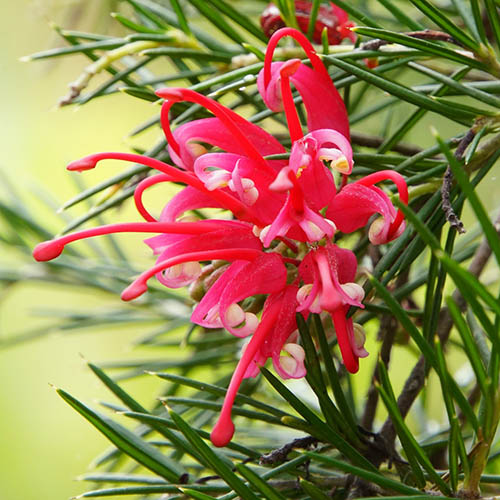

Finally, the last chart shows the distribution of the number of observations and count of records by plant Order. 

In [ ]:
plantdf.dtypes

Scientific Name    object
Order              object
plant_id            int16
ratings_counts      int64
dtype: object

In [ ]:
# Display the number of observations per plant and count of plants per Order.
alt.hconcat(
    filtered_hist('ratings_counts', '# observations / plant', genre_filter),
    #filtered_hist('rating mean', 'mean plant rating', genre_filter),
    genre_chart,
    data=plantdf)

alt.HConcatChart(...)

# II. Preliminaries

Our goal is to factorize the plant observations matrix $A$ into the product of a location embedding matrix $U$ and plant species embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of locations,
- $M$ is the number of plant species,
- $A_{ij}$ is the rating of the $j$th plants by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing plant $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



## Sparse Representation of the Observations Matrix

The observations matrix could be very large and, in general, most of the entries are unobserved, since a given location will only observe a small subset of plants. For efficient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

#### Toy example
Assume we have $2$ locations and $4$ plants. Our toy observations dataframe has three ratings,

loc\_id | plant\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

The corresponding rating matrix is

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

And the SparseTensor representation is,
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```



### Build a tf.SparseTensor representation of the Rating Matrix.

In this step, we'll write a function that maps from our `plants` DataFrame to a `tf.SparseTensor`.

In [ ]:
def build_rating_sparse_tensor(plants_df):
  """
  Args:
    plants_df: a pd.DataFrame with `loc_id`, `plant_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the plants matrix.
  """
  indices = plants_df[['loc_id', 'plant_id']].values
  values = plants_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[locdf.shape[0], plantdf.shape[0]])

## Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.



### Mean Squared Error

This TensorFlow function takes a sparse rating matrix $A$ and the two embedding matrices $U, V$ and returns the mean squared error $\text{MSE}(A, UV^\top)$.

  * in this section, we only consider observed entries when calculating the loss.
  * a `SparseTensor` `sp_x` is a tuple of three Tensors: `sp_x.indices`, `sp_x.values` and `sp_x.dense_shape`.
  * you may find [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd) and  [`tf.losses.mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error) helpful.

In [ ]:
def sparse_mean_square_error(sparse_ratings, loc_embeddings, plant_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    plant_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of plant j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(loc_embeddings, plant_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

Note: One approach is to compute the full prediction matrix $UV^\top$, then gather the entries corresponding to the observed pairs. The memory cost of this approach is $O(NM)$. For the Atlas of Living Australia dataset, this is fine, as the dense $N \times M$ matrix is small enough to fit in memory ($N = 127$, $M = 3227$).

Another approach (given in the alternate solution below) is to only gather the embeddings of the observed pairs, then compute their dot products. The memory cost is $O(|\Omega| d)$ where $d$ is the embedding dimension. In our case, $|\Omega| = 10^5$, and the embedding dimension is on the order of $10$, so the memory cost of both methods is comparable. But when the number of users or plants is much larger, the first approach becomes infeasible.

In [ ]:
#@title Alternate Solution
def sparse_mean_square_error(sparse_ratings, loc_embeddings, plant_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    plant_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of plant j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(loc_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(plant_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

### Exercise 3 (Optional): adding your own ratings to the data set

You have the option to add your own ratings to the data set. If you choose to do so, you will be able to see recommendations for yourself.

Start by checking the box below. Running the next cell will authenticate you to your google Drive account, and create a spreadsheet, that contains all plant species in column 'A'. Follow the link to the spreadsheet and take 3 minutes to rate some of the plants. Your ratings should be entered in column 'B'.

In [ ]:
USER_RATINGS = True #@param {type:"boolean"}

In [ ]:
#@title Run to create a spreadsheet, then use it to enter your ratings. { form-width: "400px" }
# Authenticate user.
if USER_RATINGS:
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  # Create the spreadsheet and print a link to it.
  try:
    sh = gc.open('User-plants')
  except(gspread.SpreadsheetNotFound):
    sh = gc.create('User-plants')

  worksheet = sh.sheet1
  names = plantdf['Scientific Name'].values
  cell_list = worksheet.range(1, 1, len(names), 1)
  for cell, name in zip(cell_list, names):
    cell.value = name
  worksheet.update_cells(cell_list)
  print("Link to the spreadsheet: "
        "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Link to the spreadsheet: https://docs.google.com/spreadsheets/d/1GT4wq532Tng4cCbWbWa54XMFK7LtadnSUL6LTyWJla0/edit


Run the next  cell to load your ratings and add them to the main `ratings` DataFrame.

In [ ]:
#@title Run to load your ratings. { form-width: "400px" }
# Load the ratings from the spreadsheet and create a DataFrame.
if USER_RATINGS:
  my_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
  my_ratings = my_ratings[my_ratings[1] != '']
  my_ratings = pd.DataFrame({
      'loc_id': "127",
      'Local Government Areas 2011': "Test Location",
      'Scientific Name': list(map(str, my_ratings[0])),
      'plant_id': list(map(str, my_ratings['index'])),
      'rating': list(map(float, my_ratings[1])),
  })
  # Remove previous ratings.
  plants = plants[plants.loc_id != "127"]
  # Add new ratings.
  plants = plants.append(my_ratings, ignore_index=True)
  # Add new user to the users DataFrame.
  if locdf.shape[0] == 127:
    df2 = pd.DataFrame([['Plants Test'], [127], [""]])

    locdf = locdf.append(locdf.iloc[126], ignore_index=True)
    #df2 = pd.DataFrame([['Plants Test'], [127], [""]])
    #locdf.append(df2, ignore_index=True)
    

    locdf["loc_id"][127] = "127"
  print("Added your %d ratings; you have great taste!" % len(my_ratings))
  #plants[plants.loc_id=="127"].merge(plantdf[['plant_id', 'Scientific Name']])

Added your 15 ratings; you have great taste!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
plantdf

,Scientific Name,Order,plant_id,ratings_counts
0,Abelia,Dipsacales,0,2
1,Abelia x grandiflora,Dipsacales,1,1
2,Abrodictyum caudatum,Hymenophyllales,2,1
3,Abrophyllum ornans,Asterales,3,2
4,Abutilon,Malvales,4,5
...,...,...,...,...
3216,Zieria pilosa,Sapindales,3216,3
3217,Zieria smithii,Sapindales,3217,16
3218,Zornia dyctiocarpa var. dyctiocarpa,Fabales,3218,7
3219,Zostera muelleri subsp. capricorni,Alismatales,3219,1


# III. Training a Matrix Factorization model

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the plant embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
plant_embeddings = model.embeddings['plant_id']
```


In [ ]:
#@title CFModel helper class (run this cell) { form-width: "100px" }
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Exercise 4: Build a Matrix Factorization model and train it

Using your `sparse_mean_square_error` function, write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [ ]:
#@title Solution { form-width: "100px" }
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "loc_id": U,
      "plant_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

Great, now it's time to train the model!

Go ahead and run the next cell, trying different parameters (embedding dimension, learning rate, iterations). The training and test errors are plotted at the end of training. You can inspect these values to validate the hyper-parameters.

Note: by calling `model.train` again, the model will continue training starting from the current values of the embeddings.

 iteration 2000: train_error=0.071828, test_error=0.788786

[{'test_error': 0.7887863, 'train_error': 0.071827695}]

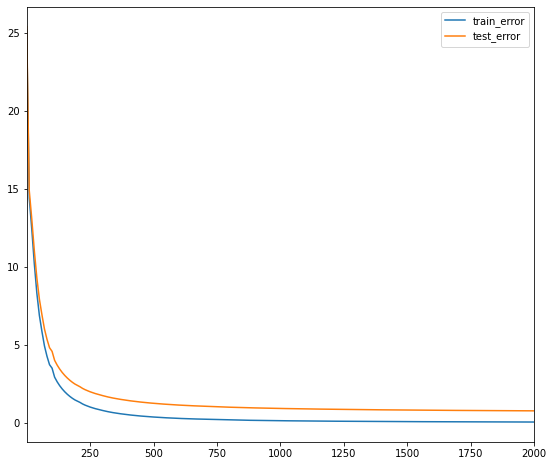

In [ ]:
# Build the CF model and train it.
model = build_model(plants, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=2000, learning_rate=2.)

# IV. Inspecting the Embeddings

In this section, we take a closer look at the learned embeddings, by
- computing your recommendations
- looking at the nearest neighbors of some plants,
- looking at the norms of the plant embeddings,
- visualizing the embedding in a projected embedding space.

### Exercise 5: Write a function that computes the scores of the candidates
We start by writing a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.

There are different similarity measures we can use, and these can yield different results. We will compare the following:
- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

Hints:
- you can use [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) to compute the product of two np.Arrays.
- you can use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) to compute the norm of a np.Array.

In [ ]:
#@title Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding (i.e. recommendations based on user selections) or a plant embedding (based on a plant's nearest neighbours).

In [ ]:
#@title User recommendations and nearest neighbors (run this cell) { form-width: "100px" }
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["loc_id"][127], model.embeddings["plant_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'plant_id': plantdf['plant_id'],
        'Scientific Name': plantdf['Scientific Name'],
        'Order': plantdf['Order'],
    })
    if exclude_rated:
      # remove plants that are already rated
      rated_plants = plants[plants.loc_id == "128"]["plant_id"].values
      df = df[df.plant_id.apply(lambda plant_id: plant_id not in rated_plants)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def plant_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for plant ids that match the given substring.
  ids =  plantdf[plantdf['Scientific Name'].str.contains(title_substring)].index.values
  titles = plantdf.iloc[ids]['Scientific Name'].values
  if len(titles) == 0:
    raise ValueError("Found no plants with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching plant. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  plant_id = ids[0]
  scores = compute_scores(
      model.embeddings["plant_id"][plant_id], model.embeddings["plant_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'Scientific Name': plantdf['Scientific Name'],
      'Order': plantdf['Order']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Your recommendations

If you chose to input your recommendations, you can run the next cell to generate recommendations for you.

In [ ]:
user_recommendations(model, measure=COSINE, k=5)

,cosine score,plant_id,Scientific Name,Order
1323,0.660,1323,Eucalyptus robusta,Myrtales
530,0.650,530,Burchardia umbellata,Liliales
1842,0.627,1842,Leptocarpus tenax,Poales
521,0.579,521,Brunoniella australis,Lamiales
2152,0.577,2152,Ochna serrulata,Malpighiales


How do the recommendations look?

### Plant Nearest neighbors

Let's look at the nearest neighbors for some of the plant species.

In [ ]:
plant_neighbors(model, "Parsonsia dorrigoensis", DOT)
plant_neighbors(model, "Parsonsia dorrigoensis", COSINE)

Nearest neighbors of : Parsonsia dorrigoensis.


,dot score,Scientific Name,Order
2235,8.147,Parsonsia dorrigoensis,Gentianales
3087,5.361,Verbascum,Lamiales
2393,4.792,Plantago debilis,Lamiales
820,4.710,Crassula colorata,Saxifragales
2217,4.689,Palmeria scandens,Laurales
1021,4.592,Digitaria violascens,Poales


Nearest neighbors of : Parsonsia dorrigoensis.


,cosine score,Scientific Name,Order
2235,1.000,Parsonsia dorrigoensis,Gentianales
3087,0.613,Verbascum,Lamiales
2217,0.573,Palmeria scandens,Laurales
1617,0.555,Hedycarya angustifolia,Laurales
2393,0.539,Plantago debilis,Lamiales
306,0.539,Asperula conferta,Gentianales


It seems that the quality of learned embeddings may not be very good. This will be addressed in Section V by adding several regularization techniques. First, we will further inspect the embeddings.

## Plant Embedding Norm

We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend common plants. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (common plants have a larger norm), which makes it more likely to recommend more common items. We can confirm this hypothesis by sorting the plants by their embedding norm, as done in the next cell.

In [ ]:
#@title Embedding Visualization code (run this cell) { form-width: "100px" }

def plant_embedding_norm(models):
  """Visualizes the norm and number of ratings of the plant embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'Scientific Name': plantdf['Scientific Name'],
      'Order': plantdf['Order'],
      'num_ratings': plantdf['ratings_counts'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["plant_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'Scientific Name', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_plant_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "Order", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'Scientific Name', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_plant_embeddings(model):
  """Visualizes the plant embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["plant_id"])
  plantdf.loc[:,'x'] = V_proj[:, 0]
  plantdf.loc[:,'y'] = V_proj[:, 1]
  return visualize_plant_embeddings(plantdf, 'x', 'y')

In [ ]:
plant_embedding_norm(model)

alt.HConcatChart(...)

Note: Depending on how the model is initialized, you may observe that some niche plants (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that plant happens to be initialized with a high norm. Then, because the plant has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.

Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximateley $\sigma \sqrt d$.

Note how this affects the embedding norm distribution, and the ranking of the top-norm plants

 iteration 2000: train_error=3.470124, test_error=3.847355Nearest neighbors of : Parsonsia dorrigoensis.


,dot score,Scientific Name,Order
2235,2.583,Parsonsia dorrigoensis,Gentianales
2611,1.570,Rhodamnia rubescens,Myrtales
2945,1.566,Syncarpia glomulifera,Myrtales
737,1.538,Cinnamomum camphora,Laurales
1371,1.471,Eustrephus latifolius,Asparagales
581,1.463,Calochlaena dubia,Cyatheales


Nearest neighbors of : Parsonsia dorrigoensis.


,cosine score,Scientific Name,Order
2235,1.000,Parsonsia dorrigoensis,Gentianales
2010,0.784,Marsdenia,Gentianales
985,0.784,Dianella congesta,Asparagales
2834,0.772,Sloanea australis,Oxalidales
1583,0.767,Guioa semiglauca,Sapindales
807,0.760,Corymbia intermedia,Myrtales


alt.HConcatChart(...)

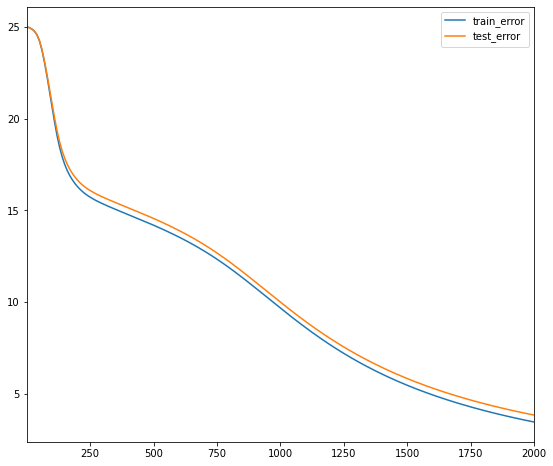

In [ ]:
#@title Solution { form-width: "100px" }
model_lowinit = build_model(plants, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=2000, learning_rate=0.1)
plant_neighbors(model_lowinit, "Parsonsia dorrigoensis", DOT)
plant_neighbors(model_lowinit, "Parsonsia dorrigoensis", COSINE)
plant_embedding_norm([model, model_lowinit])

## Embedding visualization
Since it is hard to visualize embeddings in a higher-dimensional space (when the embedding dimension $k > 3$), one approach is to project the embeddings to a lower dimensional space. T-SNE (T-distributed Stochastic Neighbor Embedding) is an algorithm that projects the embeddings while attempting to preserve their pariwise distances. It can be useful for visualization, but one should use it with care. For more information on using t-SNE, see [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/).

In [ ]:
tsne_plant_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3221 samples in 0.001s...
[t-SNE] Computed neighbors for 3221 samples in 0.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3221
[t-SNE] Computed conditional probabilities for sample 2000 / 3221
[t-SNE] Computed conditional probabilities for sample 3000 / 3221
[t-SNE] Computed conditional probabilities for sample 3221 / 3221
[t-SNE] Mean sigma: 0.144671
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.532570
[t-SNE] KL divergence after 400 iterations: 2.671127


alt.HConcatChart(...)

You can highlight the embeddings of a given genre by clicking on the genres panel (SHIFT+click to select multiple genres).

We can observe that the embeddings do not seem to have any notable structure, and the embeddings of a given genre are located all over the embedding space. This confirms the poor quality of the learned embeddings. One of the main reasons, which we will address in the next section, is that we only trained the model on observed pairs, and without regularization.

# V. Regularization In Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  As discussed in the lecture, this can be problematic as the model does not learn how to place the embeddings of irrelevant plants. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

### Exercise 6: Build a regularized Matrix Factorization model and train it
Write a function that builds a regularized model. You are given a function `gravity(U, V)` that computes the gravity term given the two embedding matrices $U$ and $V$.


In [ ]:
#@title Solution { form-width: "100px" }
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of plant ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"loc_id": U, "plant_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

It is now time to train the regularized model! You can try different values of the regularization coefficients, and different embedding dimensions.

 iteration 1000: train_error_observed=0.878675, test_error_observed=1.508474, observed_loss=0.878675, regularization_loss=0.461178, gravity_loss=0.950907

[{'test_error_observed': 1.5084738, 'train_error_observed': 0.878675},
 {'gravity_loss': 0.9509071,
  'observed_loss': 0.878675,
  'regularization_loss': 0.4611784}]

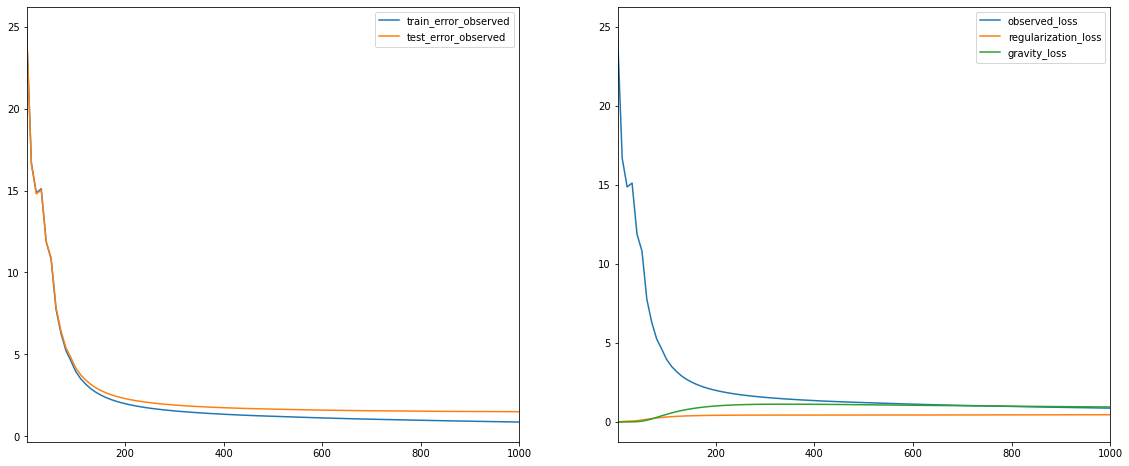

In [ ]:
reg_model = build_regularized_model(
    plants, regularization_coeff=0.05, gravity_coeff=0.5, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=1000, learning_rate=2.)

Observe that adding the regularization terms results in a higher MSE, both on the training and test set. However, as we will see, the quality of the recommendations improves. This highlights a tension between fitting the observed data and minimizing the regularization terms. Fitting the observed data often emphasizes learning high similarity (between items with many interactions), but a good embedding representation also requires learning low similarity (between items with few or no interactions).

### Inspect the results
Let's see if the results with regularization look better.

In [ ]:
user_recommendations(reg_model, COSINE, exclude_rated=True, k=10)

,cosine score,plant_id,Scientific Name,Order
2315,0.763,2315,Persoonia pinifolia,Proteales
272,0.763,272,Aristea ecklonii,Asparagales
1603,0.762,1603,Hakea propinqua,Proteales
233,0.750,233,Angophora hispida,Myrtales
453,0.747,453,Boronia ledifolia,Sapindales
2045,0.746,2045,Melaleuca hypericifolia,Myrtales
1942,0.738,1942,Lomandra gracilis,Asparagales
614,0.735,614,Carduus,Asterales
180,0.734,180,Aloe vera,Asparagales
470,0.730,470,Bossiaea scolopendria,Fabales


Hopefully, these recommendations look better. You can change the similarity measure from COSINE to DOT and observe how this affects the recommendations.

Since the model is likely to recommend items that you rated highly, you have the option to exclude the items you rated, using `exclude_rated=True`.

In the following cells, we display the nearest neighbors, the embedding norms, and the t-SNE projection of the plant embeddings.

In [ ]:
plant_neighbors(reg_model, "Ranunculus anemoneus", DOT)
plant_neighbors(reg_model, "Ranunculus anemoneus", COSINE)

Nearest neighbors of : Ranunculus anemoneus.


,dot score,Scientific Name,Order
2585,5.803,Ranunculus anemoneus,Ranunculales
2687,5.528,Rytidosperma pumilum,Poales
1049,5.495,Diuris ochroma,Asparagales
1362,3.500,Euphrasia collina subsp. diversicolor,Lamiales
2529,3.337,Pterostylis monticola,Asparagales
2481,3.315,Prasophyllum bagoense,Asparagales


Nearest neighbors of : Ranunculus anemoneus.


,cosine score,Scientific Name,Order
2585,1.000,Ranunculus anemoneus,Ranunculales
1049,0.980,Diuris ochroma,Asparagales
2687,0.976,Rytidosperma pumilum,Poales
1362,0.974,Euphrasia collina subsp. diversicolor,Lamiales
1363,0.951,Euphrasia collina subsp. glacialis,Lamiales
2486,0.939,Prasophyllum tadgellianum,Asparagales


Here we compare the embedding norms for `model` and `reg_model`. Selecting a subset of the embeddings will highlight them on both charts simultaneously.

In [ ]:
plant_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

In [ ]:
# Visualize the embeddings
tsne_plant_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3221 samples in 0.000s...
[t-SNE] Computed neighbors for 3221 samples in 0.361s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3221
[t-SNE] Computed conditional probabilities for sample 2000 / 3221
[t-SNE] Computed conditional probabilities for sample 3000 / 3221
[t-SNE] Computed conditional probabilities for sample 3221 / 3221
[t-SNE] Mean sigma: 0.159859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.862976
[t-SNE] KL divergence after 400 iterations: 1.276210


alt.HConcatChart(...)

We should observe that the embeddings have a lot more structure than the unregularized case. Try selecting different genres and observe how they tend to form clusters (for example Horror, Animation and Children).

### Conclusion
This concludes this section on matrix factorization models. Note that while the scale of the problem is small enough to allow efficient training using SGD, many practical problems need to be trained using more specialized algorithms such as Alternating Least Squares (see [tf.contrib.factorization.WALSMatrixFactorization](https://www.tensorflow.org/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) for a TF implementation).